Keras also supports a simpler interface to save both the model weights and model architecture together into a single `H5` file. Saving the model in this way includes everything we need to know about the model, including:
- Model weights.
- Model architecture.
- Model compilation details (loss and metrics). 
- Model optimizer state.
This means that we can load and use the model directly, without having to re-compile it as we did in the examples above. This is the preferred way for saving and loading your Keras model.

### 1. How to Save a Keras Model 

In [1]:
# MLP for Pima Indians Dataset saved to single file
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
# load pima indians dataset
dataset = pd.read_csv('diabetes.csv')
dataset.columns = ['NTP', 'PGC','DBP','TSFT','2hSI','BMI','DPF','Age','OnDiab']

"""
NTP: Number of times pregnant.
PGC: Plasma glucose concentration a 2 hours in an oral glucose tolerance test. 3. Diastolic blood pressure (mm Hg).
TSFT: Triceps skin fold thickness (mm).
2hSI: 2-Hour serum insulin (mu U/ml).
BMI: Body mass index.
DPF: Diabetes pedigree function.
Age: Age (years).
OnDiab: Class, onset of diabetes within five years.
"""
# split into input (X) and output (Y) variables
X = dataset.drop("OnDiab",axis=1)
Y = dataset["OnDiab"]
# define model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X, Y, epochs=150, batch_size=10, verbose=0)
# evaluate the model
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

accuracy: 71.97%
Saved model to disk


### 2. How to Load a Keras Model
Your saved model can then be loaded later by calling the `load_model()` function and passing the filename. The function returns the model with the same architecture and weights.

In [2]:
# load and evaluate a saved model
import pandas as pd
from keras.models import load_model
# load model
model = load_model('model.h5')
# summarize model.
model.summary()
# load dataset
dataset = pd.read_csv('diabetes.csv')
dataset.columns = ['NTP', 'PGC','DBP','TSFT','2hSI','BMI','DPF','Age','OnDiab']
# split into input (X) and output (Y) variables
X = dataset.drop("OnDiab",axis=1)
Y = dataset["OnDiab"]
# evaluate the model
score = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
accuracy: 71.97%


### 3. Checkpoint Neural Network Model Improvements

Application checkpointing is a fault tolerance technique for long running processes. It is an approach where a snapshot of the state of the system is taken in case of system failure. If there is a problem, not all is lost. The checkpoint may be used directly, or used as the starting point for a new run, picking up where it left off. When training deep learning models, the checkpoint captures the weights of the model. These weights can be used to make predictions as-is, or used as the basis for ongoing training.

The Keras library provides a checkpointing capability by a callback API. The `ModelCheckpoint` callback class allows you to define where to checkpoint the model weights, how the file should be named and under what circumstances to make a checkpoint of the model. The API allows you to specify which metric to monitor, such as loss or accuracy on the training or validation dataset. You can specify whether to look for an improvement in maximizing or minimizing the score. Finally, the filename that you use to store the weights can include variables like the epoch number or metric. The `ModelCheckpoint` instance can then be passed to the training process when calling the `fit()` function on the model.

##### Arguments
- **filepath:** string, path to save the model file.
- **monitor:** quantity to monitor.
- **verbose:** verbosity mode, 0 or 1.
- **save_best_only:** if save_best_only=True, the latest best model according to the quantity monitored will not be overwritten.
- **save_weights_only:** if True, then only the model’s weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
- **mode:** one of {auto, min, max}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, etc. In auto mode, the direction is automatically inferred from the name of the monitored quantity.
- **period:** Interval (number of epochs) between checkpoints.

A good use of checkpointing is to output the model weights each time an improvement is observed during training. Checkpointing is set up to save the network weights only when there is an improvement in classification accuracy on the validation dataset `(monitor=’val accuracy’ and mode=’max’)`. The weights are stored in a file that includes the score in the filename `weights-improvement-epoch-val accuracy=.2f.hdf5`.

In [3]:
# Checkpoint the weights when validation accuracy improves
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import pandas as pd
# load pima indians dataset
dataset = pd.read_csv('diabetes.csv')
dataset.columns = ['NTP', 'PGC','DBP','TSFT','2hSI','BMI','DPF','Age','OnDiab']
# split into input (X) and output (Y) variables
X = dataset.drop("OnDiab",axis=1)
Y = dataset["OnDiab"]
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.44488, saving model to weights-improvement-01-0.44.hdf5

Epoch 2: val_accuracy improved from 0.44488 to 0.52756, saving model to weights-improvement-02-0.53.hdf5

Epoch 3: val_accuracy did not improve from 0.52756

Epoch 4: val_accuracy improved from 0.52756 to 0.57087, saving model to weights-improvement-04-0.57.hdf5

Epoch 5: val_accuracy did not improve from 0.57087

Epoch 6: val_accuracy improved from 0.57087 to 0.62992, saving model to weights-improvement-06-0.63.hdf5

Epoch 7: val_accuracy did not improve from 0.62992

Epoch 8: val_accuracy did not improve from 0.62992

Epoch 9: val_accuracy did not improve from 0.62992

Epoch 10: val_accuracy improved from 0.62992 to 0.64173, saving model to weights-improvement-10-0.64.hdf5

Epoch 11: val_accuracy improved from 0.64173 to 0.64567, saving model to weights-improvement-11-0.65.hdf5

Epoch 12: val_accuracy did not improve from 0.64567

Epoch 13: val_accuracy did not improve from 0.64567

### 4. Checkpoint Best Neural Network Model Only
A simpler checkpoint strategy is to save the model weights to the same file, if and only if the validation accuracy improves. This can be done easily using the same code from above and changing the output filename to be fixed (not include score or epoch information). In this case, model weights are written to the file `weights.best.hdf5` only if the classification accuracy of the model on the validation dataset improves over the best seen so far. 

In [4]:
# Checkpoint the weights for best model on validation accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import pandas as pd
# load pima indians dataset
dataset = pd.read_csv('diabetes.csv')
dataset.columns = ['NTP', 'PGC','DBP','TSFT','2hSI','BMI','DPF','Age','OnDiab']
# split into input (X) and output (Y) variables
X = dataset.drop("OnDiab",axis=1)
Y = dataset["OnDiab"]
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.53937, saving model to weights.best.hdf5

Epoch 2: val_accuracy improved from 0.53937 to 0.57480, saving model to weights.best.hdf5

Epoch 3: val_accuracy improved from 0.57480 to 0.57874, saving model to weights.best.hdf5

Epoch 4: val_accuracy did not improve from 0.57874

Epoch 5: val_accuracy did not improve from 0.57874

Epoch 6: val_accuracy improved from 0.57874 to 0.58268, saving model to weights.best.hdf5

Epoch 7: val_accuracy improved from 0.58268 to 0.59843, saving model to weights.best.hdf5

Epoch 8: val_accuracy improved from 0.59843 to 0.60630, saving model to weights.best.hdf5

Epoch 9: val_accuracy improved from 0.60630 to 0.64173, saving model to weights.best.hdf5

Epoch 10: val_accuracy did not improve from 0.64173

Epoch 11: val_accuracy improved from 0.64173 to 0.64961, saving model to weights.best.hdf5

Epoch 12: val_accuracy did not improve from 0.64961

Epoch 13: val_accuracy improved from 0.64961 to 0.65354, saving

### 5. Loading a Saved Neural Network Model

Now that you have seen how to checkpoint your deep learning models during training, you need to review how to load and use a checkpointed model. The checkpoint only includes the model weights. It assumes you know the network structure. In the example below, the model structure is known and the best weights are loaded from the previous experiment, stored in the working directory in the `weights.best.hdf5` file. The model is then used to make predictions on the entire dataset.

In [5]:
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# load weights
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
# load pima indians dataset
dataset = pd.read_csv('diabetes.csv')
dataset.columns = ['NTP', 'PGC','DBP','TSFT','2hSI','BMI','DPF','Age','OnDiab']
# split into input (X) and output (Y) variables
X = dataset.drop("OnDiab",axis=1)
Y = dataset["OnDiab"]
# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))     
                       

Created model and loaded weights from file
accuracy: 75.62%


### 6. Visualize Model Training History in Keras


In [6]:
# Visualize training history
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
# load pima indians dataset
dataset = pd.read_csv('diabetes.csv')
dataset.columns = ['NTP', 'PGC','DBP','TSFT','2hSI','BMI','DPF','Age','OnDiab']

# split into input (X) and output (Y) variables
X = dataset.drop("OnDiab",axis=1)
Y = dataset["OnDiab"]
# define model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=500, batch_size=20, verbose=0)
# list all data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


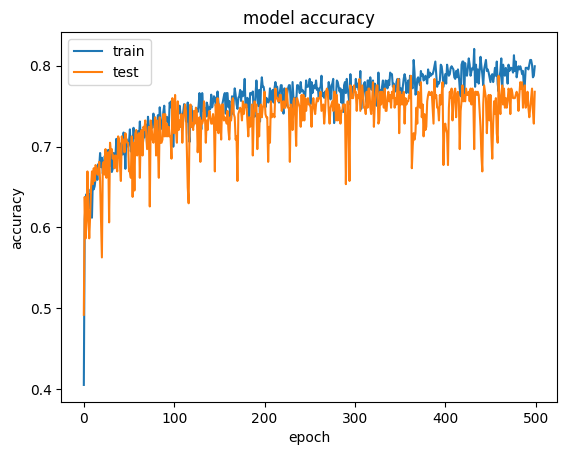

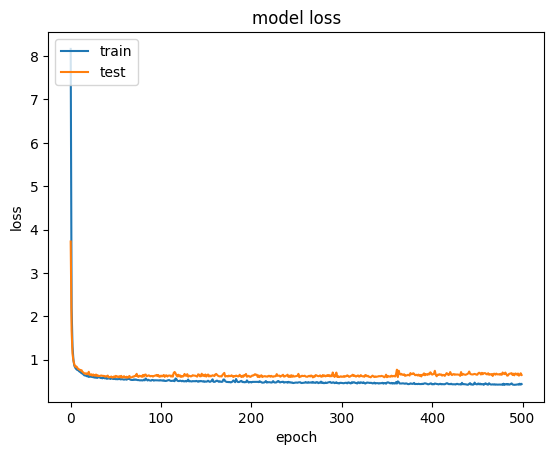

In [7]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
X.shape

(767, 8)